## ADD COMMENTS THROUGHOUT CODE (IT'S GETTING COMPLICATED)
## Note: Need to re-run all models with restrictions on maximum water on surface, in mantle (this will affect the degassing/regassing rates, cycling itself by extension).---> IMPLEMENT IN SS AND HYB MODELS!!!
## Note2: Could only save initial/final values to file to save harddrive space, depending on what is plotted in the end.
## Note3: Check if degassing=regassing at end of simulations (steady-state), or if they are not the same and the amount of water in the reservoirs will keep changing with time.
## Note4: Maybe eventually run starting with no water on surface/in mantle? Trivial for 0/0 case, but could be interesting starting with water in only one reservoir. (Is this even physically possible?)
## Note5: XXX Can update degassing/regassing functions to include capacities, so that when maximum capacity is reached, the rates go to zero -- won't look great plotted, though XXX

In [1]:
%pylab inline
import math
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pylab import *
from scipy.integrate import ode
#from mpl_toolkits.axes_grid.inset_locator import inset_axes
import time
import os.path

Populating the interactive namespace from numpy and matplotlib


In [2]:
# 1) Unchanging constants
# [M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry]

params1 = np.loadtxt('const_params.txt')
M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1

# 2) Varied parameters
# [x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
#  T_serp, K_cnst, gamma, r_fug, d_b]

params2 = np.loadtxt('vary_params.txt')
x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
     T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2

# 3) Changing parameters
# [omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt]

params3 = np.loadtxt('change_params.txt')
omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3

In [3]:
## WATER FUGACITY
# Need to calculate non-dimensional water fugacity at each step.
# Formula original from Li et al. (2008), based on experimental data.
def lnf_w(x_twid, params1, params2, params3): #NOTE: Takes non-dimensionalized mantle water mass fraction and converts it.
    c0 = -7.9859
    c1 = 4.3559
    c2 = -0.5742
    c3 = 0.0337
    B = 2.0e6
    mu_oliv = 153.31
    mu_wat = 18.01528
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    x = x_twid*omega_0*f_btwid/f_M
    ln_term = np.log((B*x*(mu_oliv/mu_wat))/(1.-(x*(mu_oliv/mu_wat))))
    
    return c0 + c1*ln_term + c2*ln_term**2. + c3*ln_term**3.

def f_wtwid(x_twid, params1, params2, params3):
    
    return np.exp(lnf_w(x_twid, params1, params2, params3)) / (np.exp(lnf_w(1., params1, params2, params3)))

In [4]:
## MANTLE VISCOSITY

# Need a function to calculate the viscosity.
def eta(T_twid, x_twid, params1, params2, params3): #x and T are non-dimensionalized later in code -- need to add dimensions back for these calculations
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    eta_scale = (np.exp(lnf_w(1.,params1,params2,params3)))**(-r_fug)
    eta_0 = 1.0e21/eta_scale
    
    x = x_twid * 2.3e-4 * 1.3 / 0.68 # mantle water mass fraction
    T = T_twid * 1600 #[K]
    
    f_w = np.exp(lnf_w(x_twid,params1,params2,params3)) #lnf_w needs non-dimensionalized x
    
    # Need a minimum fugacity, to avoid f_w --> 0 and eta --> infinity.
    if f_w > f_w_min:
        return eta_0 * (f_w**(-r_fug)) * np.exp((E_a/R_g)*((1./T) - (1./T_ref)))
    elif f_w <= f_w_min:
        return eta_0 * (f_w_min**(-r_fug)) * np.exp((E_a/R_g)*((1./T) - (1./T_ref)))

In [5]:
def Rp(M):
    M_E = 5.972e24
    R_E = 6.371e6
    return R_E*(M/M_E)**0.27

def Rc(M):
    M_E = 5.972e24
    R_E = 6.371e6
    return 0.547*R_E*(M/M_E)**0.25

def h(M):
    return Rp(M) - Rc(M)

def g(M):
    G = 6.67e-11
    return G*M/(Rp(M)**2.)

def gtwid(M): #dimensionless gravity, normalized to Earth (FOR NOW)
    return g(M)/9.8

def A(M):
    return 4.*np.pi*(Rp(M)**2.)

def V(M):
    return (4.*np.pi/3.)*((Rp(M)**3.) - (Rc(M)**3.))

def F_0(M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    eta_scale = (np.exp(lnf_w(1.,params1,params2,params3)))**(-r_fug)
    eta_0 = 1.e21/eta_scale

    f_w = np.exp(lnf_w(1.,params1,params2,params3))
    return (k*(T_ref**(1.+beta))*A(M)/(h(M)*V(M)))*(alpha*rho_m*g(M)*(h(M)**3.)*f_w/(Ra_c*kappa*eta_0))**beta

def L_MOR(M):
    return 1.5*2.*np.pi*Rp(M)

def S(T_twid, x_twid, M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    x = x_twid * omega_0 * f_btwid / f_M # mantle water mass fraction
    T = T_twid * T_ref #[K]
    
    return 10.76*(kappa**(1.-2.*beta))*(h(M)**(6.*beta-1.))*((alpha*rho_m*g(M)*(T-T_s)/(eta(T_twid,x_twid,params1,params2,params3)*Ra_c))**(2.*beta))

def tau(M, params1, params2, params3): #useful for converting between different non-dimensional timescales
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    return (L_MOR(M)*(0.1/year)*x_h*rho_c*chi*d_hE)/(M*omega_0*f_btwid) #spreading rate independent of temp in this model

def tau_decay_twid(M,params1,params2,params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    return 2.0e9*year/(rho_m*c_p*T_ref/F_0(M,params1,params2,params3))
    # return 2.0e9*3.154e7/(rho_m*c_p*T_ref/Q_0) #TEST Q_0 against F_0 in taudecay

def F_0twid(M,params1,params2,params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    return F_0(M,params1,params2,params3)/Q_0

In [6]:
# Things that need to be calculated with constants and above functions:
omg_Etwid = num_oceans*omega_E/omega_0
omegatwid = omg_Etwid/(f_btwid)
T_stwid = T_s/T_ref
T_mtwid = T_ref*R_g/E_a
T_liqtwid = T_liq_dry/T_ref
T_soltwid = T_sol_dry/T_ref
Ktwid = K_cnst/T_ref
Xtwid = x_h*rho_c*chi*d_hE*f_M/(rho_m*d_melt*f_degasE*omega_0*f_btwid)
Pi = (rho_m*d_melt*chi_d*(omega_0*f_btwid/f_M)*((T_liqtwid-T_soltwid)**-theta))
lambdatwid = Ktwid*(omega_0*f_btwid/f_M)**(gamma)
eta_scale = (np.exp(lnf_w(1.,params1,params2,params3)))**(-r_fug)
eta_0 = 1.e21/eta_scale
f_w = np.exp(lnf_w(1.,params1,params2,params3))
f_wtwid_min = f_w_min/np.exp(lnf_w(1.,params1,params2,params3)) #CONSERVATIVELY CHOSEN AS 1e-5 FOR NOW
E = rho_m*d_melt*f_degasE*omega_0*f_btwid/f_M
#tau_heat = Q_0/(rho_m*c_p*T_ref)

# 4) Calculated parameters
params4 = [omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E]

# Parameter Space Search

In [7]:
# Need to vary certain values above. Initially, start with 4 variables to be changed.

# Initial surface water, initial mantle water -- 1 ocean = 1.4e21 kg
initial_s_array = np.array([1.4e21, 10*1.4e21, 50*1.4e21])/M_E/(omega_0*f_btwid)
initial_x_array = np.array([1.4e21, 6*1.4e21, 12*1.4e21])/M_E/(omega_0*f_btwid)

# Loss rate, loss timescale
loss_factor_array = np.array([0., 10., 60.])
loss_time_array = np.array([1.0e7, 1.0e8, 1.0e9])

In [8]:
print(9.338573376374134*M_E*(omega_0*f_btwid)/1.4e21)

11.910870072077282


# Initialize CA Model

In [9]:
# Define functions for change in 1) mantle temperature, 2) mantle water mass fraction, 3) surface water mass fraction.

def f_delta_temp_CA(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum fugacity, to avoid f_wtwid --> 0 and eta --> infinity.  
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        return ((1./F_0twid(M,params1,params2,params3))*np.exp(-t_twid/tau_decay_twid(M,params1,params2,params3))) - \
            ((f_wtwid(x_twid,params1,params2,params3)**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))
    #elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
    else:
        return ((1./F_0twid(M,params1,params2,params3))*np.exp(-t_twid/tau_decay_twid(M,params1,params2,params3))) - \
            ((f_wtwid_min**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))

def f_delta_x_CA(t_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs
        
        #Degassing check from CA2014 paper
        if ((gtwid(M)**2.)*s_twid)**(-mu) < (1./f_degasE):
            dg_CA = (Xtwid**-1.)*x_twid*((gtwid(M)**2.)*s_twid)**(-mu)
        else:
            dg_CA = (Xtwid**-1.)*x_twid*(1./f_degasE)
        
        #Regassing check from CA2014 paper
        if ((gtwid(M)**2.)*s_twid)**sigma < (d_b/d_hE):
            rg_CA = ((gtwid(M)**2.)*s_twid)**sigma
        else:
            rg_CA = (d_b/d_hE)
        
        # Can't store more water in mantle than its capacity.  XXX CAN MAKE THIS MORE ROBUST LATER XXX
        dx_twid = rg_CA - dg_CA
        
        return dx_twid
    
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        
        #Regassing check from CA2014 paper
        if ((gtwid(M)**2.)*s_twid)**sigma < (d_b/d_hE):
            dx_twid = ((gtwid(M)**2.)*s_twid)**sigma - 0.
        else:
            dx_twid = (d_b/d_hE) - 0. 
            
        return dx_twid
    
    elif x_twid > 0. and s_twid <= 0.: #no regassing if no water on surface
        
        dx_twid = 0. - (Xtwid**-1.)*x_twid*(1./f_degasE) #from degassing check from CA2014 paper, or else degas blows up
    
        return dx_twid
    
    else: #no degassing, no regassing
        return 0. - 0.
    
def f_delta_s_CA(t_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Terms for loss # XXXX ALL CONDITIONS HERE CAN BE CHANGED LATER XXXX
    #loss_factor = 10.*(Xtwid**-1.)*omegatwid/2.*((gtwid(M)**2.)*omegatwid/2.)**(-mu)
    # loss factor is 10 times the initial degassing rate (FOR NOW)
    
    #loss_factor = 0. # This will turn off the atmospheric loss.
    #loss_factor = 10.*loss_factor #EXTREME LOSS -- WILL THE CODE WORK????
    
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs
        
        # Degassing check from CA2014 paper
        if ((gtwid(M)**2.)*s_twid)**(-mu) < (1./f_degasE):
            dg_CA = (Xtwid**-1.)*x_twid*((gtwid(M)**2.)*s_twid)**(-mu)
        else:
            dg_CA = (Xtwid**-1.)*x_twid*(1./f_degasE)
        
        #Regassing check from CA2014 paper
        if ((gtwid(M)**2.)*s_twid)**sigma < (d_b/d_hE):
            rg_CA = ((gtwid(M)**2.)*s_twid)**sigma
        else:
            rg_CA = (d_b/d_hE)
        
        ds_twid = dg_CA - rg_CA - loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
        
        # Can't lose more water than is actually on the surface.
        if s_twid + (ds_twid*dt) >= 0.:
            return ds_twid
        elif s_twid + (ds_twid*dt) < 0.:
            return -(s_twid/dt)
    
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        
        #Regassing check from CA2014 paper
        if ((gtwid(M)**2.)*s_twid)**sigma < (d_b/d_hE):
            ds_twid = 0. - ((gtwid(M)**2.)*s_twid)**sigma - loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
        else:
            ds_twid = 0. - (d_b/d_hE) - loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
        
        # Can't lose more water than is actually on the surface.
        if s_twid + (ds_twid*dt) >= 0.:
            return ds_twid
        elif s_twid + (ds_twid*dt) < 0.:
            return -(s_twid/dt)
    
    elif x_twid > 0. and s_twid <= 0.: #no regassing or lose if no water on surface
        
        ds_twid = (Xtwid**-1.)*x_twid*(1./f_degasE) - 0. - 0. #from degassing check from CA2014 paper, or else degas blows up
    
        # Can't lose more water than is actually on the surface.
        if s_twid + (ds_twid*dt) >= 0.:
            return ds_twid
        elif s_twid + (ds_twid*dt) < 0.:
            return -(s_twid/dt)
    
    else: #no degassing, no regassing
        return 0. - 0. - 0.
    
# Combine the change in temperature, x, and s into one cycling function to be integrated.
def f_cycling_CA(t_twid, z, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    temp_twid = z[0]
    x_twid = z[1]
    s_twid = z[2]
    
    return [(F_0(M,params1,params2,params3)/(rho_m*c_p*T_ref*tau(M,params1,params2,params3)))*\
                f_delta_temp_CA(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4),\
                f_delta_x_CA(t_twid, x_twid, s_twid, M, params1, params2, params3, params4),\
                f_delta_s_CA(t_twid, x_twid, s_twid, M, params1, params2, params3, params4)]

In [10]:
### Define functions for regassing and degassing rates, at each step (water content-dependent).

def f_regas_CA(t_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Regassing check from CA2014
    if s_twid > 0. and ((gtwid(M)**2.)*s_twid)**sigma < (d_b/d_hE): #normal regassing
        return ((gtwid(M)**2.)*s_twid)**sigma
    elif s_twid > 0. and ((gtwid(M)**2.)*s_twid)**sigma >= (d_b/d_hE):
        return (d_b/d_hE)
    else: #if s_twid <= 0; no regassing
        return 0.
    
def f_degas_CA(t_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Degassing check from CA2014
    if x_twid > 0. and s_twid > 0. and ((gtwid(M)**2.)*s_twid)**(-mu) < (1./f_degasE): #normal degassing
        return (Xtwid**-1.)*x_twid*((gtwid(M)**2.)*s_twid)**(-mu)
    elif x_twid > 0. and s_twid > 0. and ((gtwid(M)**2.)*s_twid)**(-mu) >= (1./f_degasE):
        return (Xtwid**-1.)*x_twid*(1./f_degasE)
    elif x_twid > 0. and s_twid <= 0.:
        return (Xtwid**-1.)*x_twid*(1./f_degasE)
    else: #if x_twid <= 0. OR s_twid <=0 ; no degassing --> depends on seafloor pressure, no water = no pressure
        return 0.
    
def f_loss_CA(t_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    #loss_factor = 0. # This will turn off the atmospheric loss.
    #loss_factor = 10.*loss_factor # EXTREME LOSS -- WILL THE CODE WORK???
    
    # OPTION 1: SEE FIGURE
    #if s_twid > 0.: #normal loss
    #    return loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
    #else: #if s_twid <= 0; no loss
    #    return 0.
    
    if ((gtwid(M)**2.)*s_twid)**(-mu) < (1./f_degasE):
        dg_CA = (Xtwid**-1.)*x_twid*((gtwid(M)**2.)*s_twid)**(-mu)
    else:
        dg_CA = (Xtwid**-1.)*x_twid*(1./f_degasE)
        
    #Regassing check from CA2014 paper
    if ((gtwid(M)**2.)*s_twid)**sigma < (d_b/d_hE):
        rg_CA = ((gtwid(M)**2.)*s_twid)**sigma
    else:
        rg_CA = (d_b/d_hE)
        
    ds_twid = dg_CA - rg_CA - loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
    
    # OPTION 2: SEE FIGURE
    # Can't lose more water than is actually on the surface.
    #if s_twid > 0. and s_twid + (ds_twid*dt) >= 0.:
    #    return loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
    #elif s_twid > 0. and s_twid + (ds_twid*dt) < 0.:
    #    return (s_twid/dt)
    #elif s_twid <= 0.:
    #    return 0.
    
    # OPTION 3: DON'T WORRY ABOUT WATER, JUST SHOW RATE
    #What if loss rate doesn't depend on surface water -- just see how it looks
    return loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)


In [11]:
# Multiply by omega_0*f_btwid*M_E to get amount of water in kg!

def omega_hydr_twid_CA(t_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    d_h = d_hE*((gtwid(M)**2.)*s_twid)**sigma #Eqn (35) in paper
    
    return (4.*np.pi/(3.*omega_0*f_btwid))*(R_E**3. - (R_E - d_h)**3.)*(x_h*rho_m/M)

# Run CA model parameter space search

In [12]:
for jdx in range(0, len(initial_s_array)):
    
    for kdx in range(0, len(initial_x_array)):
        
        for ldx in range(0, len(loss_factor_array)):
            
            for mdx in range(0, len(loss_time_array)):
                
                t_loss = loss_time_array[mdx]
                loss_factor = loss_factor_array[ldx]
        
                M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
                x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
                    T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
                params3 = [omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt]
                omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
                omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
                    eta_scale, eta_0, f_w, f_wtwid_min, E = params4

                # Set initial conditions.
                t0 = 0.
                z0 = [2., initial_x_array[kdx], initial_s_array[jdx]]
                M = M_E

                # Set up function to be integrated.
                r = ode(f_cycling_CA).set_integrator('vode')
                r.set_initial_value(z0, t0).set_f_params(M,params1,params2,params3,params4)

                # Define max time, timestep, arrays to be filled within the integration loop.
                t1 = 5.22 #~15 Gyr #100.
                dt = 1.e-5
                t_array_CA = np.zeros(int(t1/dt)+1)
                T_array_CA = np.zeros(int(t1/dt)+1)
                x_array_CA = np.zeros(int(t1/dt)+1)
                s_array_CA = np.zeros(int(t1/dt)+1)
                regas_array_CA = np.zeros(int(t1/dt)+1)
                degas_array_CA = np.zeros(int(t1/dt)+1)
                loss_array_CA = np.zeros(int(t1/dt)+1)
                omega_hydr_array_CA = np.zeros(int(t1/dt)+1)
                eta_array_CA = np.zeros(int(t1/dt)+1)
                
                # Write results to file, for plotting later.
                save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search/'
                save_file = 'cycling_CA_test' + str(jdx) + str(kdx) + str(ldx) + str(mdx) + '.txt'
                filename = os.path.join(save_path, save_file)
                f = open(filename, 'w')

                # Initial values in the arrays.
                t_array_CA[0] = t0
                T_array_CA[0] = z0[0]
                x_array_CA[0] = z0[1]
                s_array_CA[0] = z0[2]
                regas_array_CA[0] = f_regas_CA(t0, z0[1], z0[2], M, params1, params2, params3, params4)
                degas_array_CA[0] = f_degas_CA(t0, z0[1], z0[2], M, params1, params2, params3, params4)
                loss_array_CA[0] = f_loss_CA(t0, z0[1], z0[2], M, params1, params2, params3, params4)
                omega_hydr_array_CA[0] = omega_hydr_twid_CA(t0, z0[1], z0[2], M, params1, params2, params3, params4)
                eta_array_CA[0] = eta(z0[0], z0[1], params1, params2, params3)
                
                f.write(str(t_array_CA[0]) + '\t' + str(T_array_CA[0]) + '\t' + str(x_array_CA[0]) +\
                            '\t' + str(s_array_CA[0]) + '\t' + str(regas_array_CA[0]) + '\t' + str(degas_array_CA[0]) + \
                            '\t' + str(loss_array_CA[0]) + '\n')

                # Integrate the above function.
                #idx = 1
                #while r.successful() and r.t < t1:
                #start_time = time.time()
                                
                for idx in range(1,len(t_array_CA)):
    
                    if r.successful() == True:
                        r.integrate(r.t+dt)
                        t_array_CA[idx] = r.t
                        T_array_CA[idx] = r.y[0]
                        x_array_CA[idx] = r.y[1]
                        s_array_CA[idx] = r.y[2]
                        regas_array_CA[idx] = f_regas_CA(r.t, r.y[1], r.y[2], M, params1, params2, params3, params4)
                        degas_array_CA[idx] = f_degas_CA(r.t, r.y[1], r.y[2], M, params1, params2, params3, params4)
                        loss_array_CA[idx] = f_loss_CA(r.t, r.y[1], r.y[2], M, params1, params2, params3, params4)
                        omega_hydr_array_CA[idx] = omega_hydr_twid_CA(r.t, r.y[1], r.y[2], M, params1, params2, params3, params4)
                        eta_array_CA[idx] = eta(r.y[0], r.y[1], params1, params2, params3)
                        
                        f.write(str(t_array_CA[idx]) + '\t' + str(T_array_CA[idx]) + '\t' + str(x_array_CA[idx]) +\
                            '\t' + str(s_array_CA[idx]) + '\t' + str(regas_array_CA[idx]) + '\t' + str(degas_array_CA[idx]) + \
                            '\t' + str(loss_array_CA[idx]) + '\n')
        
                    elif r.successful() == False:
        
                        t_array_CA[idx] = t_array_CA[idx-1] + dt
        
                        T_array_CA[idx] = T_array_CA[idx-1] + \
                            f_delta_temp_CA(t_array_CA[idx-1], T_array_CA[idx-1], x_array_CA[idx-1], s_array_CA[idx-1], M, params1, params2, params3, params4)*dt
                        x_array_CA[idx] = x_array_CA[idx-1] + \
                            f_delta_x_CA(t_array_CA[idx-1], x_array_CA[idx-1], s_array_CA[idx-1], M, params1, params2, params3, params4)*dt
                        s_array_CA[idx] = s_array_CA[idx-1] + \
                            f_delta_s_CA(t_array_CA[idx-1], x_array_CA[idx-1], s_array_CA[idx-1], M, params1, params2, params3, params4)*dt
        
                        regas_array_CA[idx] = f_regas_CA(t_array_CA[idx], x_array_CA[idx], s_array_CA[idx], M, params1, params2, params3, params4)
                        degas_array_CA[idx] = f_degas_CA(t_array_CA[idx], x_array_CA[idx], s_array_CA[idx], M, params1, params2, params3, params4)
                        loss_array_CA[idx] = f_loss_CA(t_array_CA[idx], x_array_CA[idx], s_array_CA[idx], M, params1, params2, params3, params4)
                        omega_hydr_array_CA[idx] = omega_hydr_twid_CA(t_array_CA[idx], x_array_CA[idx], s_array_CA[idx], M, params1, params2, params3, params4)
                        eta_array_CA[idx] = eta(T_array_CA[idx], x_array_CA[idx], params1, params2, params3)
                        
                        f.write(str(t_array_CA[idx]) + '\t' + str(T_array_CA[idx]) + '\t' + str(x_array_CA[idx]) +\
                            '\t' + str(s_array_CA[idx]) + '\t' + str(regas_array_CA[idx]) + '\t' + str(degas_array_CA[idx]) + \
                            '\t' + str(loss_array_CA[idx]) + '\n')
        
                        # Leave the loop if both reservoirs have zero water.
                        if x_array_CA[idx] <= 0. and s_array_CA[idx] <= 0.:
                            break
        
                        #idx = idx + 1
    
                f.close()
                
                #end_time = time.time()
                #print(end_time-start_time, ' s')
    
                # Mass of water in hydrated layer
                M_hydr_CA = omega_hydr_array_CA*2.3e-4*1.3*M_E #[kg]          

/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: overflow encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: overflow encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/scipy/integrate/_od

In [ ]:
save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search/'
save_file = 'cycling_CA_test2000.txt' #change this to see different results
filename = os.path.join(save_path, save_file)
tmp_data = np.loadtxt(filename)
t_array_CA = tmp_data[:,0]
T_array_CA = tmp_data[:,1]
x_array_CA = tmp_data[:,2]
s_array_CA = tmp_data[:,3]
regas_array_CA = tmp_data[:,4]
degas_array_CA = tmp_data[:,5]
loss_array_CA = tmp_data[:,6]

In [ ]:
## %matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
ax = [fig.add_subplot(1,2,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg] # THIS IS CORRECT, FOR BOTH X AND S!!!

ax1 = plt.subplot(1,2,1)
plt.semilogx(t_array_CA/tau(M_E,params1,params2,params3)/year/1.0e9, (x_array_CA*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='Mantle')
plt.semilogx(t_array_CA/tau(M_E,params1,params2,params3)/year/1.0e9, (s_array_CA*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Surface')
#The below 2 lines are for plotting the hydrated layer.
#plt.semilogx(t_array_CA*2.87, ((s_array_CA*kg_conv/1000./1.0e18)-M_hydr_CA/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Ocean')
#plt.semilogx(t_array_CA*2.87, M_hydr_CA/1000./1.0e18, linewidth=3, color='b', linestyle='-', label='Hydrated Layer')
#plt.semilogx([0., 287], [1.32*kg_conv/1000./1.0e18, 1.32*kg_conv/1000./1.0e18], color='k', linestyle='--', label='Earth Mantle Water')
#plt.semilogx([0., 287], [1.39, 1.39], color='k', linestyle=':', label='Earth Surface Water')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Water Mass [$10^{21}$ kg]', fontsize=16)
plt.legend(loc='lower left', fontsize=16)

# Conversion factor for degassing and regassing to units: (mass transport flux in [kg m^-2 s^-1])
# Literature tends to list global degassing rates in [mol yr^-1]; others simply use [g yr^1]; CA paper used [kg yr^-1]
# 1 mol H2O = 18.01528 g = 0.01801528 kg; 1 yr = 31536000 s
# Maybe try (10^18 tons)/(10^6 yr) = exatons/Myr
# degassing: (kg_conv**2)/(9.8**2)... 
# regassing: (kg_conv**2)/(9.8**2)
dr_conv = (L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year #[kg/yr] MY CALCULATION
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = (3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

ax2 = plt.subplot(1,2,2)
#could also multiply by dr_conv*exa_gyr_conv to get 10^21 kg/Gyr
plt.semilogx(t_array_CA/tau(M_E,params1,params2,params3)/year/1.0e9, (degas_array_CA*dr_conv/1.0e11), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array_CA/tau(M_E,params1,params2,params3)/year/1.0e9, (regas_array_CA*dr_conv/1.0e11), linewidth=3, color='r', linestyle=':', label='Regassing')
#plt.semilogx(t_array_CA/tau(M_E,params1,params2,params3)/year/1.0e9, (loss_array_CA*dr_conv/1.0e11), linewidth=3, color='k', linestyle='-.', label='Atmospheric Loss')
plt.xlabel('Time [Gyr]', fontsize=16)
#plt.ylabel(r'Flux Rate [$10^{21}$ kg/Gyr]', fontsize=16)
plt.ylabel(r'Flux Rate [$10^{11}$ kg/yr]', fontsize=16)
#plt.ylim([0,0.2])
plt.legend(loc='center left', fontsize=16)
#plt.savefig('Recoded_CA_model_cycling_noloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_CA_model_cycling_exploss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_CA_model_cycling_extremeloss.pdf', bbox_inches='tight')

In [ ]:
#Interesting cycling:
#0010, 0022, 0111, 0122, 1000, 1012, 1022, 1112, 1122, 2022, 2222

# Initialize SS Model

In [ ]:
# Define functions to be used within this model (and hybrid), based on mass.

def D(M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return x_h*rho_c*chi_r*(h(M)**(1.-3.*beta))*((T_serp-T_s)/(T_ref**(1.+beta)))*\
        (kappa*Ra_c*eta_0/(alpha*rho_m*g(M)*f_w))**beta

def Sigma(M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return M*omega_0*f_btwid*((h(M)**(1.-6.*beta))*(kappa**(2.*beta-1.))/\
        (10.76*L_MOR(M)))*(Ra_c*eta_0/(alpha*rho_m*g(M)*T_ref*f_w))**(2.*beta)

def tau_SS(M, params1, params2, params3, params4):
    
    return D(M, params1, params2, params3, params4)/Sigma(M, params1, params2, params3, params4)

def Pitwid(M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return Pi/D(M, params1, params2, params3, params4)

def D_2(M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return (h(M)**(1.-3.*beta))*((T_serp-T_s)/(T_ref**(1.+beta)))*((kappa*Ra_c*eta_0)/(alpha*rho_m*g(M)*np.exp(lnf_w(1., params1, params2, params3))))**beta

def D_2_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        return (Rp(M)-((Rp(M)**3.)-((3.*omega_0*f_btwid*M*s_twid)/(4.*np.pi*x_h*rho_m)))**(1./3.))*\
            np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid(x_twid,params1,params2,params3)**beta)*((temp_twid-T_stwid)**(1.+beta))
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        return (Rp(M)-((Rp(M)**3.)-((3.*omega_0*f_btwid*M*s_twid)/(4.*np.pi*x_h*rho_m)))**(1./3.))*\
            np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_min**beta)*((temp_twid-T_stwid)**(1.+beta))

def Pitwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return Pi/(D_2_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4)*x_h*rho_c*chi_r)

#tau_heat = Q_0/(rho_m*c_p*T_ref) #NOTE: TAD USES F_0 IN PLACE OF Q_0 IN THIS TIMESCALE

In [ ]:
# Define functions for change in 1) mantle temperature, 2) mantle water mass fraction, 3) surface water mass fraction.

# XXXX ARE THE MANTLE TEMPERATURE FUNCTIONS THE SAME NOW? IF SO, ONLY DEFINE ONE XXXX
def f_delta_temp_SS(t_twid, temp_twid, x_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        return ((1./F_0twid(M,params1,params2,params3))*np.exp(-t_twid/tau_decay_twid(M,params1,params2,params3))) - \
            ((f_wtwid(x_twid,params1,params2,params3)**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        return ((1./F_0twid(M,params1,params2,params3))*np.exp(-t_twid/tau_decay_twid(M,params1,params2,params3))) - \
            ((f_wtwid_min**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))

def f_delta_x_SS(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid

    if x_twid > 0. and s_twid > 0.: #water in both reservoirs

        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                return (1./Pitwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta)
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                return (1./Pitwid_max(temp_twid, x_twid, s_twid,M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta)
            elif s_twid <= 0:
                return 0. - (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta)
                
        else: #temperature below solidus temperature, degassing shuts off
            
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                return (1./Pitwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                return (1./Pitwid_max(temp_twid, x_twid, s_twid,M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
            elif s_twid <= 0:
                return 0. - 0.
            
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        # Solidus check not needed here, since no water in mantle in this case
        
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            return (1./Pitwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            return (1./Pitwid_max(temp_twid, x_twid, s_twid,M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
        elif s_twid <= 0:
            return 0. - 0.
        
    elif x_twid > 0. and s_twid <= 0: #no regassing if no water on surface (also no loss)
        
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
        # No hydrated layer check needed if no water on surface
            return 0. - (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta)
                
        else: #temperature below solidus temperature, degassing shuts off
            
            return 0. - 0.
        
    elif x_twid <= 0. and s_twid <= 0.: #no degassing, no regassing, no loss --> DESSICATED
        # no need for solidus temperature check or hydrated layer check if no water left on planet in any reservoirs
        return 0. - 0.
                    
def f_delta_s_SS(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4): # NEED TO ADD LOSS TO THIS 
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    # This can either turn off loss, or increase the loss rate.
    #loss_factor = 0.
    loss_factor = 10.*loss_factor # EXTREME loss
        
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs

        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                ds_twid = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta) - \
                    (1./Pitwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                    - (1./Pitwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                ds_twid = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta) - \
                    (1./Pitwid_max(temp_twid, x_twid, s_twid,M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                    - (1./Pitwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
            elif s_twid <= 0:
                ds_twid = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta) - 0. \
                    - 0.
                
        else: #temperature below solidus temperature, degassing shuts off
            
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                ds_twid = 0. - (1./Pitwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                    - (1./Pitwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                ds_twid = 0. - (1./Pitwid_max(temp_twid, x_twid, s_twid,M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                    - (1./Pitwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
            elif s_twid <= 0:
                return 0. - 0. - 0.
            
        # Can't lose more water than is actually on the surface.
        if s_twid + (ds_twid*dt) >= 0.:
            return ds_twid
        elif s_twid + (ds_twid*dt) < 0.:
            return -(s_twid/dt)
            
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        # Solidus check not needed here, since no water in mantle in this case
        
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            ds_twid = 0. - (1./Pitwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                - (1./Pitwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            ds_twid = 0. - (1./Pitwid_max(temp_twid, x_twid, s_twid,M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                - (1./Pitwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
        elif s_twid <= 0:
            ds_twid = 0. - 0. - 0.
            
        # Can't lose more water than is actually on the surface.
        if s_twid + (ds_twid*dt) >= 0.:
            return ds_twid
        elif s_twid + (ds_twid*dt) < 0.:
            return -(s_twid/dt)
        
    elif x_twid > 0. and s_twid <= 0: #no regassing if no water on surface (also no loss)
        
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
        # No hydrated layer check needed if no water on surface
            return (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta) - 0. - 0.
                
        else: #temperature below solidus temperature, degassing shuts off
            
            return 0. - 0. - 0.
        
    elif x_twid <= 0. and s_twid <= 0.: #no degassing, no regassing, no loss --> DESSICATED
        # no need for solidus temperature check or hydrated layer check if no water left on planet in any reservoirs
        return 0. - 0. - 0.
    
# Combine the change in temperature, x, and s into one cycling function to be integrated.
def f_cycling_SS(t_twid, z, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
        
    temp_twid = z[0]
    x_twid = z[1]
    s_twid = z[2]
    
    # Dividing by tau(M) helps put these on the same timescale.
    return [(F_0(M,params1,params2,params3)/(rho_m*c_p*T_ref*tau(M,params1,params2,params3)))*\
                f_delta_temp_SS(t_twid, temp_twid, x_twid, M, params1, params2, params3, params4),\
                (Pi/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3)))*\
                f_delta_x_SS(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4),\
                (Pi/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3)))*\
                f_delta_s_SS(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4)]

In [ ]:
# Define functions for regassing and degassing rates, at each step (water content-dependent).

def f_regas_SS(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if s_twid > 0.: #water on surface
        
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            return (1./Pitwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            return (1./Pitwid_max(temp_twid, x_twid, s_twid,M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
        elif s_twid < 0:
            return 0.
                
    elif s_twid <= 0.: #no water on surface; no regassing
        return 0.
    
def f_degas_SS(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if x_twid > 0.: #water in mantle
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
        # No hydrated layer check needed if no water on surface
            return (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta)
                
        else: #temperature below solidus temperature, degassing shuts off
            return 0.
                                                                                        
    elif x_twid <= 0.: #no water in mantle; no degassing
        return 0.
    
def f_loss_SS(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # This can either turn off loss, or increase the loss rate.
    #loss_factor = 0.
    loss_factor = 10.*loss_factor # EXTREME loss
    
# OPTION 2: CAN ADD OPTION 1 OR 3 BASED ON CA RESULTS LATER XXXXXX
#    if s_twid > 0.: #normal loss
#        return (1./Pitwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
#    elif s_twid <= 0.: #no loss
#        return 0.

# OPTION 3: DON'T WORRY ABOUT WATER, JUST SHOW RATE
    return (1./Pitwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)

In [ ]:
def omega_hydr_twid_SS(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if hydr_lhs <= hydr_rhs and s_twid > 0.:
        d_h = D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))
    elif hydr_lhs > hydr_rhs and s_twid > 0.:
        d_h = D_2_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))
    elif s_twid <= 0.:
        d_h = 0.
        
    return (4.*np.pi/(3.*omega_0*f_btwid))*(R_E**3. - (R_E - d_h)**3.)*(x_h*rho_m/M)
    

# Run parameter space search for SS model

In [ ]:
for jdx in range(0, len(initial_s_array)):
    
    for kdx in range(0, len(initial_x_array)):
        
        for ldx in range(0, len(loss_factor_array)):
            
            for mdx in range(0, len(loss_time_array)):
                
                t_loss = loss_time_array[mdx]
                loss_factor = loss_factor_array[ldx]
        
                M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
                x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
                    T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
                params3 = [omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt]
                omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
                omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
                    eta_scale, eta_0, f_w, f_wtwid_min, E = params4

                # Set initial conditions.
                t0 = 0.
                z0 = [2., initial_x_array[kdx], initial_s_array[jdx]]
                M = M_E

                # Set up function to be integrated.
                r = ode(f_cycling_SS).set_integrator('vode')
                r.set_initial_value(z0, t0).set_f_params(M,params1,params2,params3,params4)

                # Define max time, timestep, arrays to be filled within the integration loop.
                t1 = 5.22 #~15 Gyr #100.
                dt = 1.e-5
                t_array_SS = np.zeros(int(t1/dt)+1)
                T_array_SS = np.zeros(int(t1/dt)+1)
                x_array_SS = np.zeros(int(t1/dt)+1)
                s_array_SS = np.zeros(int(t1/dt)+1)
                regas_array_SS = np.zeros(int(t1/dt)+1)
                degas_array_SS = np.zeros(int(t1/dt)+1)
                loss_array_SS = np.zeros(int(t1/dt)+1)
                omega_hydr_array_SS = np.zeros(int(t1/dt)+1)
                eta_array_SS = np.zeros(int(t1/dt)+1)
                
                # Write results to file, for plotting later.
                save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search/'
                save_file = 'cycling_SS_test' + str(jdx) + str(kdx) + str(ldx) + str(mdx) + '.txt'
                filename = os.path.join(save_path, save_file)
                f = open(filename, 'w')

                # Initial values in the arrays.
                t_array_SS[0] = t0
                T_array_SS[0] = z0[0]
                x_array_SS[0] = z0[1]
                s_array_SS[0] = z0[2]
                regas_array_SS[0] = f_regas_SS(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
                degas_array_SS[0] = f_degas_SS(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
                loss_array_SS[0] = f_loss_SS(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
                omega_hydr_array_SS[0] = omega_hydr_twid_SS(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
                #eta_array_SS[0] = eta(z0[0], z0[1], params1, params2, params3)
                
                f.write(str(t_array_SS[0]) + '\t' + str(T_array_SS[0]) + '\t' + str(x_array_SS[0]) +\
                            '\t' + str(s_array_SS[0]) + '\t' + str(regas_array_SS[0]) + '\t' + str(degas_array_SS[0]) + \
                            '\t' + str(loss_array_SS[0]) + '\n')

                # Integrate the above function.
                #idx = 1
                #while r.successful() and r.t < t1:
                #start_time = time.time()
                                
                for idx in range(1,len(t_array_SS)):
    
                    if r.successful() == True:
                        r.integrate(r.t+dt)
                        t_array_SS[idx] = r.t
                        T_array_SS[idx] = r.y[0]
                        x_array_SS[idx] = r.y[1]
                        s_array_SS[idx] = r.y[2]
                        regas_array_SS[idx] = f_regas_SS(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
                        degas_array_SS[idx] = f_degas_SS(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
                        loss_array_SS[idx] = f_loss_SS(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
                        omega_hydr_array_SS[idx] = omega_hydr_twid_SS(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
                        #eta_array_SS[idx] = eta(r.y[0], r.y[1], params1, params2, params3)
                        
                        f.write(str(t_array_SS[idx]) + '\t' + str(T_array_SS[idx]) + '\t' + str(x_array_SS[idx]) +\
                            '\t' + str(s_array_SS[idx]) + '\t' + str(regas_array_SS[idx]) + '\t' + str(degas_array_SS[idx]) + \
                            '\t' + str(loss_array_SS[idx]) + '\n')
        
                    elif r.successful() == False:
        
                        t_array_SS[idx] = t_array_SS[idx-1] + dt
        
                        T_array_SS[idx] = T_array_SS[idx-1] + \
                            f_delta_temp_SS(t_array_SS[idx-1], T_array_SS[idx-1], x_array_SS[idx-1], M, params1, params2, params3, params4)*dt
                        x_array_SS[idx] = x_array_SS[idx-1] + \
                            f_delta_x_SS(t_array_SS[idx-1], T_array_SS[idx-1], x_array_SS[idx-1], s_array_SS[idx-1], M, params1, params2, params3, params4)*dt
                        s_array_SS[idx] = s_array_SS[idx-1] + \
                            f_delta_s_SS(t_array_SS[idx-1], T_array_SS[idx-1], x_array_SS[idx-1], s_array_SS[idx-1], M, params1, params2, params3, params4)*dt
        
                        regas_array_SS[idx] = f_regas_SS(t_array_SS[idx], T_array_SS[idx-1], x_array_SS[idx], s_array_SS[idx], M, params1, params2, params3, params4)
                        degas_array_SS[idx] = f_degas_SS(t_array_SS[idx], T_array_SS[idx-1], x_array_SS[idx], s_array_SS[idx], M, params1, params2, params3, params4)
                        loss_array_SS[idx] = f_loss_SS(t_array_SS[idx], T_array_SS[idx-1], x_array_SS[idx], s_array_SS[idx], M, params1, params2, params3, params4)
                        omega_hydr_array_SS[idx] = omega_hydr_twid_SS(t_array_SS[idx], T_array_SS[idx-1], x_array_SS[idx], s_array_SS[idx], M, params1, params2, params3, params4)
                        #eta_array_SS[idx] = eta(T_array_SS[idx], x_array_SS[idx], params1, params2, params3)
                        
                        f.write(str(t_array_SS[idx]) + '\t' + str(T_array_SS[idx]) + '\t' + str(x_array_SS[idx]) +\
                            '\t' + str(s_array_SS[idx]) + '\t' + str(regas_array_SS[idx]) + '\t' + str(degas_array_SS[idx]) + \
                            '\t' + str(loss_array_SS[idx]) + '\n')
        
                        # Leave the loop if both reservoirs have zero water.
                        if x_array_SS[idx] <= 0. and s_array_SS[idx] <= 0.:
                            break
        
                        #idx = idx + 1
    
                f.close()
                
                #end_time = time.time()
                #print(end_time-start_time, ' s')
    
                # Mass of water in hydrated layer
                M_hydr_SS = omega_hydr_array_SS*2.3e-4*1.3*M_E #[kg]          

In [ ]:
save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search/'
save_file = 'cycling_SS_test0000.txt' #change this to see different results
filename = os.path.join(save_path, save_file)
tmp_data = np.loadtxt(filename)
t_array_SS = tmp_data[:,0]
T_array_SS = tmp_data[:,1]
x_array_SS = tmp_data[:,2]
s_array_SS = tmp_data[:,3]
regas_array_SS = tmp_data[:,4]
degas_array_SS = tmp_data[:,5]
loss_array_SS = tmp_data[:,6]

In [ ]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
ax = [fig.add_subplot(1,2,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg]
rate_mult_SS = (Pi/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3))) #multiply rates to get actual rate from paper

ax = plt.subplot(1,2,1)
plt.semilogx(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, (x_array_SS*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='Mantle')
plt.semilogx(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, (s_array_SS*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Surface')
#The below 2 lines are for plotting the hydrated layer.
#plt.semilogx(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, ((s_array_SS*kg_conv/1000./1.0e18)-M_hydr_SS/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Ocean')
#plt.semilogx(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, M_hydr_SS/1000./1.0e18, linewidth=3, color='b', linestyle='-', label='Hydrated Layer')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Water Mass [$10^{21}$ kg]', fontsize=16)
plt.legend(loc='lower left', fontsize=16)

# Conversion factor for degassing and regassing to units: (mass transport flux in [kg m^-2 s^-1])
# Literature tends to list global degassing rates in [mol yr^-1]; others simply use [g yr^1]; CA paper used [kg yr^-1]
# 1 mol H2O = 18.01528 g = 0.01801528 kg; 1 yr = 31536000 s
# Maybe try (10^18 tons)/(10^6 yr) = exatons/Myr
# degassing: (kg_conv**2)/(9.8**2)... 
# regassing: (kg_conv**2)/(9.8**2)
dr_conv = (L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year #[kg/yr]
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = (3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

ax = plt.subplot(1,2,2)
plt.semilogx(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_SS*degas_array_SS*dr_conv/1.0e14), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_SS*regas_array_SS*dr_conv/1.0e14), linewidth=3, color='r', linestyle=':', label='Regassing')
#plt.semilogx(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_SS*loss_array_SS*dr_conv/1.0e14), linewidth=3, color='k', linestyle='-.', label='Atmospheric Loss')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Flux Rate [$10^{14}$ kg/yr]', fontsize=16)
#plt.ylim([-1, 5.])
plt.legend(loc='upper right', fontsize=16)
#plt.savefig('Recoded_SS_model_cycling_noloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_SS_model_cycling_exploss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_SS_model_cycling_extremeloss.pdf', bbox_inches='tight')

In [ ]:
#Interesting results:
#0000, 0010, 0011, 0120, 0121, 0220, 1000, 1020, 1220, 2121, 2212, 2222

# Initialize hybrid model

In [ ]:
# Many functions have already been defined for the SS model -- only define new things here.

def Etwid(M,params1,params2,params3,params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return E/D(M,params1,params2,params3,params4)

def Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return E/(D_2_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4)*x_h*rho_c*chi_r)

In [ ]:
# Define functions for change in 1) mantle temperature, 2) mantle water mass fraction, 3) surface water mass fraction.
def f_delta_temp_hyb(t_twid, temp_twid, x_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        return ((1./F_0twid(M,params1,params2,params3))*np.exp(-t_twid/tau_decay_twid(M,params1,params2,params3))) - \
            ((f_wtwid(x_twid,params1,params2,params3)**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        return ((1./F_0twid(M,params1,params2,params3))*np.exp(-t_twid/tau_decay_twid(M,params1,params2,params3))) - \
            ((f_wtwid_min**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))

def f_delta_x_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs
        
        #Degassing check from CA2014
        if ((gtwid(M)**2.)*s_twid)**-1. < (1./f_degasE):
            dg_hyb = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((gtwid(M)**2.)*s_twid)**(-1.)
        else:
            dg_hyb = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
        
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            return (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                dg_hyb
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            return (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                dg_hyb
        elif s_twid <= 0:
             return 0. - (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
            
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            return (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            return (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
        elif s_twid <= 0:
             return 0. - 0.
            
    elif x_twid > 0. and s_twid <= 0.: #no regassing if no water on surface
        #No need for hydrated layer check if no water on surface
        #Degassing check from CA2014 (only one option for degas though)
        return 0. - (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
    
    elif x_twid <= 0. and s_twid <= 0.: #no degassing, no regassing
        return 0. - 0.
    
def f_delta_s_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    # This can either turn loss off, or change the loss rate.
    #loss_factor = 0.
    loss_factor = 10.*loss_factor # EXTREME loss
    
    ##loss_factor = 100.*loss_factor #EXTREME loss
    
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs
        
        #Degassing check from CA2014
        if ((gtwid(M)**2.)*s_twid)**-1. < (1./f_degasE):
            dg_hyb = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((gtwid(M)**2.)*s_twid)**(-1.)
        else:
            dg_hyb = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
        
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            ds_twid = dg_hyb - \
                (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            ds_twid = dg_hyb - \
                (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
        elif s_twid <= 0:
            ds_twid = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*(1./f_degasE) - 0. - 0.
            
        # Can't lose more water than is actually on the surface.
        if s_twid + (ds_twid*dt) >= 0.:
            return ds_twid
        elif s_twid + (ds_twid*dt) < 0.:
            return -(s_twid/dt)
            
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            ds_twid = 0. - (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            ds_twid = 0. - (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
        elif s_twid <= 0:
            ds_twid = 0. - 0. - 0.
            
        # Can't lose more water than is actually on the surface.
        if s_twid + (ds_twid*dt) >= 0.:
            return ds_twid
        elif s_twid + (ds_twid*dt) < 0.:
            return -(s_twid/dt)
            
    elif x_twid > 0. and s_twid <= 0.: #no regassing if no water on surface
        #No need for hydrated layer check if no water on surface
        return (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*(1./f_degasE) - 0. - 0.
    
    elif x_twid <= 0. and s_twid <= 0.: #no degassing, no regassing
        return 0. - 0. - 0.
    
# Combine the change in temperature, x, and s into one cycling function to be integrated.
def f_cycling_hyb(t_twid, z, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    temp_twid = z[0]
    x_twid = z[1]
    s_twid = z[2]
    
    return [(F_0(M,params1,params2,params3)/(rho_m*c_p*T_ref*tau(M,params1,params2,params3)))*\
                f_delta_temp_hyb(t_twid, temp_twid, x_twid, M, params1, params2, params3, params4),\
                (E/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3)))*\
                f_delta_x_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4),\
                (E/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3)))*\
                f_delta_s_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4)]
    

In [ ]:
# Define functions for regassing and degassing rates, at each step (water content-dependent).

def f_regas_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if s_twid > 0.:
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            return (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            return (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
        elif s_twid <= 0:
             return 0.
            
    elif s_twid <= 0.:
        return 0.
    
def f_degas_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    # Degassing check from CA2014
    if x_twid > 0. and s_twid > 0. and ((gtwid(M)**2.)*s_twid)**(-mu) < (1./f_degasE): #normal degassing
        return (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((gtwid(M)**2.)*s_twid)**(-1.)
    elif x_twid > 0. and s_twid > 0. and ((gtwid(M)**2.)*s_twid)**(-mu) >= (1./f_degasE):
        return (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
    elif x_twid > 0. and s_twid <= 0.:
        return (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
    else: #if x_twid <= 0. OR s_twid <=0 ; no degassing --> depends on seafloor pressure, no water = no pressure
        return 0.
    
def f_loss_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # This can either turn loss off, or change the loss rate.
    #loss_factor = 0.
    loss_factor = 10.*loss_factor #EXTREME loss

    ##loss_factor = 100.*loss_factor #EXTREME loss
    
    #if s_twid > 0.: #normal loss
    return (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
    #elif s_twid <= 0.: #no loss
    #    return 0.

In [ ]:
def omega_hydr_twid_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if hydr_lhs <= hydr_rhs and s_twid > 0.:
        d_h = D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))
    elif hydr_lhs > hydr_rhs and s_twid > 0.:
        d_h = D_2_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))
    elif s_twid <= 0.:
        d_h = 0.
        
    return (4.*np.pi/(3.*omega_0*f_btwid))*(R_E**3. - (R_E - d_h)**3.)*(x_h*rho_m/M)  

# Run parameter space search for hybrid model

In [ ]:
for jdx in range(0, len(initial_s_array)):
    
    for kdx in range(0, len(initial_x_array)):
        
        for ldx in range(0, len(loss_factor_array)):
            
            for mdx in range(0, len(loss_time_array)):
                
                t_loss = loss_time_array[mdx]
                loss_factor = loss_factor_array[ldx]
        
                M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
                x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
                    T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
                params3 = [omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt]
                omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
                omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
                    eta_scale, eta_0, f_w, f_wtwid_min, E = params4

                # Set initial conditions.
                t0 = 0.
                z0 = [2., initial_x_array[kdx], initial_s_array[jdx]]
                M = M_E

                # Set up function to be integrated.
                r = ode(f_cycling_hyb).set_integrator('vode')
                r.set_initial_value(z0, t0).set_f_params(M,params1,params2,params3,params4)

                # Define max time, timestep, arrays to be filled within the integration loop.
                t1 = 5.22 #~15 Gyr #100.
                dt = 1.e-5
                t_array_hyb = np.zeros(int(t1/dt)+1)
                T_array_hyb = np.zeros(int(t1/dt)+1)
                x_array_hyb = np.zeros(int(t1/dt)+1)
                s_array_hyb = np.zeros(int(t1/dt)+1)
                regas_array_hyb = np.zeros(int(t1/dt)+1)
                degas_array_hyb = np.zeros(int(t1/dt)+1)
                loss_array_hyb = np.zeros(int(t1/dt)+1)
                omega_hydr_array_hyb = np.zeros(int(t1/dt)+1)
                eta_array_hyb = np.zeros(int(t1/dt)+1)
                
                # Write results to file, for plotting later.
                save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search/'
                save_file = 'cycling_hyb_test' + str(jdx) + str(kdx) + str(ldx) + str(mdx) + '.txt'
                filename = os.path.join(save_path, save_file)
                f = open(filename, 'w')

                # Initial values in the arrays.
                t_array_hyb[0] = t0
                T_array_hyb[0] = z0[0]
                x_array_hyb[0] = z0[1]
                s_array_hyb[0] = z0[2]
                regas_array_hyb[0] = f_regas_hyb(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
                degas_array_hyb[0] = f_degas_hyb(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
                loss_array_hyb[0] = f_loss_hyb(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
                omega_hydr_array_hyb[0] = omega_hydr_twid_hyb(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
                #eta_array_hyb[0] = eta(z0[0], z0[1], params1, params2, params3)
                
                f.write(str(t_array_hyb[0]) + '\t' + str(T_array_hyb[0]) + '\t' + str(x_array_hyb[0]) +\
                            '\t' + str(s_array_hyb[0]) + '\t' + str(regas_array_hyb[0]) + '\t' + str(degas_array_hyb[0]) + \
                            '\t' + str(loss_array_hyb[0]) + '\n')

                # Integrate the above function.
                #idx = 1
                #while r.successful() and r.t < t1:
                #start_time = time.time()
                                
                for idx in range(1,len(t_array_hyb)):
    
                    if r.successful() == True:
                        r.integrate(r.t+dt)
                        t_array_hyb[idx] = r.t
                        T_array_hyb[idx] = r.y[0]
                        x_array_hyb[idx] = r.y[1]
                        s_array_hyb[idx] = r.y[2]
                        regas_array_hyb[idx] = f_regas_hyb(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
                        degas_array_hyb[idx] = f_degas_hyb(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
                        loss_array_hyb[idx] = f_loss_hyb(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
                        omega_hydr_array_hyb[idx] = omega_hydr_twid_hyb(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
                        #eta_array_hyb[idx] = eta(r.y[0], r.y[1], params1, params2, params3)
                        
                        f.write(str(t_array_hyb[idx]) + '\t' + str(T_array_hyb[idx]) + '\t' + str(x_array_hyb[idx]) +\
                            '\t' + str(s_array_hyb[idx]) + '\t' + str(regas_array_hyb[idx]) + '\t' + str(degas_array_hyb[idx]) + \
                            '\t' + str(loss_array_hyb[idx]) + '\n')
        
                    elif r.successful() == False:
        
                        t_array_hyb[idx] = t_array_hyb[idx-1] + dt
        
                        T_array_hyb[idx] = T_array_hyb[idx-1] + \
                            f_delta_temp_hyb(t_array_hyb[idx-1], T_array_hyb[idx-1], x_array_hyb[idx-1], M, params1, params2, params3, params4)*dt
                        x_array_hyb[idx] = x_array_hyb[idx-1] + \
                            f_delta_x_hyb(t_array_hyb[idx-1], T_array_hyb[idx-1], x_array_hyb[idx-1], s_array_hyb[idx-1], M, params1, params2, params3, params4)*dt
                        s_array_hyb[idx] = s_array_hyb[idx-1] + \
                            f_delta_s_hyb(t_array_hyb[idx-1], T_array_hyb[idx-1], x_array_hyb[idx-1], s_array_hyb[idx-1], M, params1, params2, params3, params4)*dt
        
                        regas_array_hyb[idx] = f_regas_hyb(t_array_hyb[idx], T_array_hyb[idx-1], x_array_hyb[idx], s_array_hyb[idx], M, params1, params2, params3, params4)
                        degas_array_hyb[idx] = f_degas_hyb(t_array_hyb[idx], T_array_hyb[idx-1], x_array_hyb[idx], s_array_hyb[idx], M, params1, params2, params3, params4)
                        loss_array_hyb[idx] = f_loss_hyb(t_array_hyb[idx], T_array_hyb[idx-1], x_array_hyb[idx], s_array_hyb[idx], M, params1, params2, params3, params4)
                        omega_hydr_array_hyb[idx] = omega_hydr_twid_hyb(t_array_hyb[idx], T_array_hyb[idx-1], x_array_hyb[idx], s_array_hyb[idx], M, params1, params2, params3, params4)
                        #eta_array_hyb[idx] = eta(T_array_hyb[idx], x_array_hyb[idx], params1, params2, params3)
                        
                        f.write(str(t_array_hyb[idx]) + '\t' + str(T_array_hyb[idx]) + '\t' + str(x_array_hyb[idx]) +\
                            '\t' + str(s_array_hyb[idx]) + '\t' + str(regas_array_hyb[idx]) + '\t' + str(degas_array_hyb[idx]) + \
                            '\t' + str(loss_array_hyb[idx]) + '\n')
        
                        # Leave the loop if both reservoirs have zero water.
                        if x_array_hyb[idx] <= 0. and s_array_hyb[idx] <= 0.:
                            break
        
                        #idx = idx + 1
    
                f.close()
                
                #end_time = time.time()
                #print(end_time-start_time, ' s')
    
                # Mass of water in hydrated layer
                M_hydr_hyb = omega_hydr_array_hyb*2.3e-4*1.3*M_E #[kg]          

In [ ]:
save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search/'
save_file = 'cycling_hyb_test0000.txt' #change this to see different results
filename = os.path.join(save_path, save_file)
tmp_data = np.loadtxt(filename)
t_array_hyb = tmp_data[:,0]
T_array_hyb = tmp_data[:,1]
x_array_hyb = tmp_data[:,2]
s_array_hyb = tmp_data[:,3]
regas_array_hyb = tmp_data[:,4]
degas_array_hyb = tmp_data[:,5]
loss_array_hyb = tmp_data[:,6]

In [ ]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
ax = [fig.add_subplot(1,2,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg]
rate_mult_hyb = (E/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3))) #multiply rates to get actual rate from paper [kg/s]

ax = plt.subplot(1,2,1)
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (x_array_hyb*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='Mantle')
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (s_array_hyb*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Surface')
#The below 2 lines are for plotting the hydrated layer.
#plt.semilogx(t_array_hyb*2.22, ((s_array_hyb*kg_conv/1000./1.0e18)-M_hydr_hyb/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Ocean')
#plt.semilogx(t_array_hyb*2.22, M_hydr_hyb/1000./1.0e18, linewidth=3, color='b', linestyle='-', label='Hydrated Layer')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Water Mass [exatons]', fontsize=16)
plt.legend(loc='lower left', fontsize=16)

dr_conv = (L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year #[kg/yr]
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = 1. #(3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

ax = plt.subplot(1,2,2)
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*degas_array_hyb*dr_conv/1.0e14), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*regas_array_hyb*dr_conv/1.0e14), linewidth=3, color='r', linestyle=':', label='Regassing')
#plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*loss_array_hyb*dr_conv/1.0e14), linewidth=3, color='k', linestyle='-.', label='Atmospheric Loss')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Flux Rate [$10^{14}$ kg/yr]', fontsize=16)
plt.legend(loc='upper right', fontsize=16)
#plt.savefig('Recoded_hyb_model_cycling_noloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_cycling_exploss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_cycling_extremeloss.pdf', bbox_inches='tight')

In [ ]:
#Interesting results:
#0010, 0020, 0110, 0112, 0120, 0220, 1000, 1022, 1220, 2000, 2021, 

# Plots of the end results

In [13]:
filenums = []

for jdx in range(0, len(initial_s_array)):
    
    for kdx in range(0, len(initial_x_array)):
        
        for ldx in range(0, len(loss_factor_array)):
            
            for mdx in range(0, len(loss_time_array)):
                
                filenums = np.append(filenums, str(jdx)+str(kdx)+str(ldx)+str(mdx))

In [14]:
# Read in data files to figure out final x and s fractions.

save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search/'
tolerance = 1e-21 #anything below this, no water (<1 kg of water)

x_initial_CA = np.zeros(len(filenums))
s_initial_CA = np.zeros(len(filenums))
x_initial_SS = np.zeros(len(filenums))
s_initial_SS = np.zeros(len(filenums))
x_initial_hyb = np.zeros(len(filenums))
s_initial_hyb = np.zeros(len(filenums))

x_final_CA = np.zeros(len(filenums))
s_final_CA = np.zeros(len(filenums))
x_final_SS = np.zeros(len(filenums))
s_final_SS = np.zeros(len(filenums))
x_final_hyb = np.zeros(len(filenums))
s_final_hyb = np.zeros(len(filenums))

x_zero_count_CA = 0.
s_zero_count_CA = 0.
both_zero_count_CA = 0.
x_zero_count_SS = 0.
s_zero_count_SS = 0.
both_zero_count_SS = 0.
x_zero_count_hyb = 0.
s_zero_count_hyb = 0.
both_zero_count_hyb = 0.

for idx in range(0,len(filenums)):
    # Read in data files for each model.
    save_file = 'cycling_CA_test' + filenums[idx] + '.txt' #change this to see different results
    filename = os.path.join(save_path, save_file)
    tmp_data = np.loadtxt(filename)
    x_array_CA = tmp_data[:,2]
    s_array_CA = tmp_data[:,3]
    
    save_file = 'cycling_SS_test' + filenums[idx] + '.txt' #change this to see different results
    filename = os.path.join(save_path, save_file)
    tmp_data = np.loadtxt(filename)
    x_array_SS = tmp_data[:,2]
    s_array_SS = tmp_data[:,3]
    
    save_file = 'cycling_hyb_test' + filenums[idx] + '.txt' #change this to see different results
    filename = os.path.join(save_path, save_file)
    tmp_data = np.loadtxt(filename)
    x_array_hyb = tmp_data[:,2]
    s_array_hyb = tmp_data[:,3]
    
    # Save initial and final values to corresponding arrays.
    x_initial_CA[idx] = x_array_CA[0]
    s_initial_CA[idx] = s_array_CA[0]
    x_initial_SS[idx] = x_array_SS[0]
    s_initial_SS[idx] = s_array_SS[0]
    x_initial_hyb[idx] = x_array_hyb[0]
    s_initial_hyb[idx] = s_array_hyb[0]
    
    x_final_CA[idx] = x_array_CA[-1]
    s_final_CA[idx] = s_array_CA[-1]
    x_final_SS[idx] = x_array_SS[-1]
    s_final_SS[idx] = s_array_SS[-1]
    x_final_hyb[idx] = x_array_hyb[-1]
    s_final_hyb[idx] = s_array_hyb[-1]
    
    # Check for zeros.
    if x_final_CA[idx] <= tolerance and s_final_CA[idx] <= tolerance:
        both_zero_count_CA = both_zero_count_CA + 1.
        x_final_CA[idx] = 0.
        s_final_CA[idx] = 0.
    elif x_final_CA[idx] <= tolerance:
        x_zero_count_CA = x_zero_count_CA + 1.
        x_final_CA[idx] = 0.
    elif s_final_CA[idx] <= tolerance:
        s_zero_count_CA = s_zero_count_CA + 1.
        s_final_CA[idx] = 0.
        
    if x_final_SS[idx] <= tolerance and s_final_SS[idx] <= tolerance:
        both_zero_count_SS = both_zero_count_SS + 1.
        x_final_SS[idx] = 0.
        s_final_SS[idx] = 0.
    elif x_final_SS[idx] <= tolerance:
        x_zero_count_SS = x_zero_count_SS + 1.
        x_final_SS[idx] = 0.
    elif s_final_SS[idx] <= tolerance:
        s_zero_count_SS = s_zero_count_SS + 1.
        s_final_SS[idx] = 0.
        
    if x_final_hyb[idx] <= tolerance and s_final_hyb[idx] <= tolerance:
        both_zero_count_hyb = both_zero_count_hyb + 1.
        x_final_hyb[idx] = 0.
        s_final_hyb[idx] = 0.
    elif x_final_hyb[idx] <= tolerance:
        x_zero_count_hyb = x_zero_count_hyb + 1.
        x_final_hyb[idx] = 0.
    elif s_final_hyb[idx] <= tolerance:
        s_zero_count_hyb = s_zero_count_hyb + 1.
        s_final_hyb[idx] = 0.
        
print('CA zeros: ', 'x: ', x_zero_count_CA, 's: ', s_zero_count_CA, 'both: ', both_zero_count_CA)
print('SS zeros: ', 'x: ', x_zero_count_SS, 's: ', s_zero_count_SS, 'both: ', both_zero_count_SS)
print('hyb zeros: ', 'x: ', x_zero_count_hyb, 's: ', s_zero_count_hyb, 'both: ', both_zero_count_hyb)

CA zeros:  x:  0.0 s:  0.0 both:  0.0
SS zeros:  x:  0.0 s:  18.0 both:  0.0
hyb zeros:  x:  0.0 s:  10.0 both:  0.0


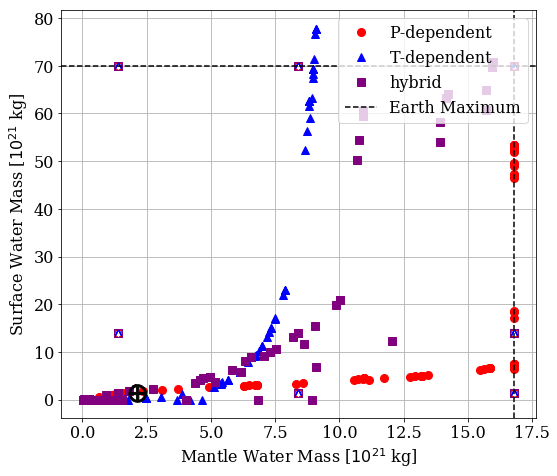

In [15]:
# Plot s vs x (in kg), on a log scale.
# Use different symbols for different models.

# Also plot initial conditions as open symbols, and connect to the final corresponding s/x.

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]

plt.plot(x_initial_CA*kg_conv/1000./1.0e18, s_initial_CA*kg_conv/1000./1.0e18,  fillstyle='none', color='r', marker='o', linestyle='', markersize=8)
plt.plot(x_initial_SS*kg_conv/1000./1.0e18, s_initial_SS*kg_conv/1000./1.0e18,  fillstyle='none', color='b', marker='^', linestyle='', markersize=8)
plt.plot(x_initial_hyb*kg_conv/1000./1.0e18, s_initial_hyb*kg_conv/1000./1.0e18,  fillstyle='none', color='purple', marker='s', linestyle='', markersize=8)
plt.plot(x_final_CA*kg_conv/1000./1.0e18, s_final_CA*kg_conv/1000./1.0e18, color='r', marker='o', linestyle='', markersize=8, label='P-dependent')
plt.plot(x_final_SS*kg_conv/1000./1.0e18, s_final_SS*kg_conv/1000./1.0e18, color='b', marker='^', linestyle='', markersize=8, label='T-dependent')
plt.plot(x_final_hyb*kg_conv/1000./1.0e18, s_final_hyb*kg_conv/1000./1.0e18, color='purple', marker='s', linestyle='', markersize=8, label='hybrid')
plt.plot(1.5*1.4, 1.4, color='k', marker='$\oplus$', markersize=20)
plt.axhline(y=50*1.4, color='k', linestyle='--', label='Earth Maximum')
plt.axvline(x=12*1.4, color='k', linestyle='--')
plt.xlabel(r'Mantle Water Mass [$10^{21}$ kg]', fontsize=16)
plt.ylabel(r'Surface Water Mass [$10^{21}$ kg]', fontsize=16)
plt.grid(which='both')
plt.legend(loc='upper right', fontsize=16)
#plt.savefig('Final_Water_parametertest_norestrictions.pdf')
#plt.savefig('Final_Water_parametertest.pdf')

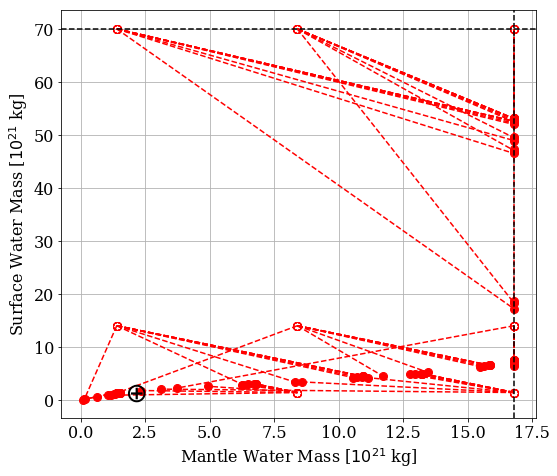

In [17]:
# Plot open marker, then filled marker, then a line connecting the two.

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
for idx in range(0,len(x_initial_CA)):
    plt.plot(x_initial_CA[idx]*kg_conv/1000./1.0e18, s_initial_CA[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color='r', marker='o', linestyle='', markersize=8)
    plt.plot(x_final_CA[idx]*kg_conv/1000./1.0e18, s_final_CA[idx]*kg_conv/1000./1.0e18, color='r', marker='o', linestyle='', markersize=8)
    plt.plot([x_initial_CA[idx]*kg_conv/1000./1.0e18, x_final_CA[idx]*kg_conv/1000./1.0e18], [s_initial_CA[idx]*kg_conv/1000./1.0e18, s_final_CA[idx]*kg_conv/1000./1.0e18], color='r', linestyle='--')
plt.plot(x_final_CA[0]*kg_conv/1000./1.0e18, s_final_CA[0]*kg_conv/1000./1.0e18, color='r', marker='o', linestyle='', markersize=8)#, label='P-dependent')
plt.plot(1.5*1.4, 1.4, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.01)
plt.axhline(y=50*1.4, color='k', linestyle='--')#, label='Earth Maximum')
plt.axvline(x=12*1.4, color='k', linestyle='--')
plt.xlabel(r'Mantle Water Mass [$10^{21}$ kg]', fontsize=16)
plt.ylabel(r'Surface Water Mass [$10^{21}$ kg]', fontsize=16)
plt.grid(which='both')
#plt.legend(loc='upper right', fontsize=16) 
plt.savefig('Parameter_Search_CA_Model.pdf')


In [ ]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
for idx in range(0,len(x_initial_SS)):
    plt.plot(x_initial_SS[idx]*kg_conv/1000./1.0e18, s_initial_SS[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color='b', marker='^', linestyle='', markersize=8)
    plt.plot(x_final_SS[idx]*kg_conv/1000./1.0e18, s_final_SS[idx]*kg_conv/1000./1.0e18, color='b', marker='^', linestyle='', markersize=8)
    plt.plot([x_initial_SS[idx]*kg_conv/1000./1.0e18, x_final_SS[idx]*kg_conv/1000./1.0e18], [s_initial_SS[idx]*kg_conv/1000./1.0e18, s_final_SS[idx]*kg_conv/1000./1.0e18], color='b', linestyle='--')
plt.plot(x_final_SS[0]*kg_conv/1000./1.0e18, s_final_SS[0]*kg_conv/1000./1.0e18, color='b', marker='^', linestyle='', markersize=8)#, label='P-dependent')
plt.plot(1.5*1.4, 1.4, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.01)
plt.axhline(y=50*1.4, color='k', linestyle='--')#, label='Earth Maximum')
plt.axvline(x=12*1.4, color='k', linestyle='--')
plt.xlabel(r'Mantle Water Mass [$10^{21}$ kg]', fontsize=16)
plt.ylabel(r'Surface Water Mass [$10^{21}$ kg]', fontsize=16)
plt.grid(which='both')
#plt.legend(loc='upper right', fontsize=16) 
#plt.savefig('Parameter_Search_SS_Model.pdf')

In [ ]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
for idx in range(0,len(x_initial_hyb)):
    plt.plot(x_initial_hyb[idx]*kg_conv/1000./1.0e18, s_initial_hyb[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color='purple', marker='s', linestyle='', markersize=8)
    plt.plot(x_final_hyb[idx]*kg_conv/1000./1.0e18, s_final_hyb[idx]*kg_conv/1000./1.0e18, color='purple', marker='s', linestyle='', markersize=8)
    plt.plot([x_initial_hyb[idx]*kg_conv/1000./1.0e18, x_final_hyb[idx]*kg_conv/1000./1.0e18], [s_initial_hyb[idx]*kg_conv/1000./1.0e18, s_final_hyb[idx]*kg_conv/1000./1.0e18], color='purple', linestyle='--')
plt.plot(x_final_hyb[0]*kg_conv/1000./1.0e18, s_final_hyb[0]*kg_conv/1000./1.0e18, color='purple', marker='s', linestyle='', markersize=8)#, label='P-dependent')
plt.plot(1.5*1.4, 1.4, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.01)
plt.axhline(y=50*1.4, color='k', linestyle='--')#, label='Earth Maximum')
plt.axvline(x=12*1.4, color='k', linestyle='--')
plt.xlabel(r'Mantle Water Mass [$10^{21}$ kg]', fontsize=16)
plt.ylabel(r'Surface Water Mass [$10^{21}$ kg]', fontsize=16)
plt.grid(which='both')
#plt.legend(loc='upper right', fontsize=16) 
#plt.savefig('Parameter_Search_hyb_Model.pdf')

In [ ]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
for idx in range(0,len(x_initial_hyb)):
    plt.plot(x_initial_CA[idx]*kg_conv/1000./1.0e18, s_initial_CA[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color='r', marker='o', linestyle='', markersize=8)
    plt.plot(x_final_CA[idx]*kg_conv/1000./1.0e18, s_final_CA[idx]*kg_conv/1000./1.0e18, color='r', marker='o', linestyle='', markersize=8)
    plt.plot([x_initial_CA[idx]*kg_conv/1000./1.0e18, x_final_CA[idx]*kg_conv/1000./1.0e18], [s_initial_CA[idx]*kg_conv/1000./1.0e18, s_final_CA[idx]*kg_conv/1000./1.0e18], color='r', linestyle='--')
    plt.plot(x_initial_SS[idx]*kg_conv/1000./1.0e18, s_initial_SS[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color='b', marker='^', linestyle='', markersize=8)
    plt.plot(x_final_SS[idx]*kg_conv/1000./1.0e18, s_final_SS[idx]*kg_conv/1000./1.0e18, color='b', marker='^', linestyle='', markersize=8)
    plt.plot([x_initial_SS[idx]*kg_conv/1000./1.0e18, x_final_SS[idx]*kg_conv/1000./1.0e18], [s_initial_SS[idx]*kg_conv/1000./1.0e18, s_final_SS[idx]*kg_conv/1000./1.0e18], color='b', linestyle='--')
    plt.plot(x_initial_hyb[idx]*kg_conv/1000./1.0e18, s_initial_hyb[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color='purple', marker='s', linestyle='', markersize=8)
    plt.plot(x_final_hyb[idx]*kg_conv/1000./1.0e18, s_final_hyb[idx]*kg_conv/1000./1.0e18, color='purple', marker='s', linestyle='', markersize=8)
    plt.plot([x_initial_hyb[idx]*kg_conv/1000./1.0e18, x_final_hyb[idx]*kg_conv/1000./1.0e18], [s_initial_hyb[idx]*kg_conv/1000./1.0e18, s_final_hyb[idx]*kg_conv/1000./1.0e18], color='purple', linestyle='--')
plt.plot(x_final_CA[0]*kg_conv/1000./1.0e18, s_final_CA[0]*kg_conv/1000./1.0e18, color='r', marker='o', linestyle='', markersize=8, label='P-dependent')
plt.plot(x_final_SS[0]*kg_conv/1000./1.0e18, s_final_SS[0]*kg_conv/1000./1.0e18, color='b', marker='^', linestyle='', markersize=8, label='T-dependent')
plt.plot(x_final_hyb[0]*kg_conv/1000./1.0e18, s_final_hyb[0]*kg_conv/1000./1.0e18, color='purple', marker='s', linestyle='', markersize=8, label='hybrid')
plt.plot(1.5*1.4, 1.4, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.01)
plt.axhline(y=50*1.4, color='k', linestyle='--', label='Earth Maximum')
plt.axvline(x=12*1.4, color='k', linestyle='--')
plt.xlabel(r'Mantle Water Mass [$10^{21}$ kg]', fontsize=16)
plt.ylabel(r'Surface Water Mass [$10^{21}$ kg]', fontsize=16)
plt.grid(which='both')
plt.legend(bbox_to_anchor=(1.0, 0.6), fontsize=16)
#plt.legend(loc='lower right', fontsize=16) 
#plt.savefig('Parameter_Search_all_Models.pdf', bbox_inches='tight')